In [148]:
import NewCore
import os
os.chdir('/Volumes/FAIR/DC-Image-Analysis/DC-project-master/cleancode/NewMidplane')
import Functions
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt

from scipy.ndimage.morphology import binary_opening as bo
from scipy.ndimage.morphology import binary_erosion as be
from scipy.ndimage.morphology import binary_closing as bc
from scipy.ndimage.morphology import binary_fill_holes as bfh

from ipywidgets import interact, fixed
from IPython.display import display

def wl_to_lh(window, level):
    low = level - window/2
    high = level + window/2
    return low,high

import skimage
from skimage import filters

def display_image(img, x=None, y=None, z=None, window=None, level=None):
    # Convert SimpleITK image to NumPy array
    img_array = sitk.GetArrayFromImage(img)
    
    # Get image dimensions in millimetres
    size = img.GetSize()
    spacing = img.GetSpacing()
    width  = size[0] * spacing[0]
    height = size[1] * spacing[1]
    depth  = size[2] * spacing[2]
    
    if x is None:
        x = np.floor(size[0]/2).astype(int)
    if y is None:
        y = np.floor(size[1]/2).astype(int)
    if z is None:
        z = np.floor(size[2]/2).astype(int)
    
    if window is None:
        window = np.max(img_array) - np.min(img_array)
    
    if level is None:
        level = window / 2 + np.min(img_array)
    
    low,high = wl_to_lh(window,level)

    # Display the orthogonal slices
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

    ax1.imshow(img_array[z,:,:], cmap='gray', clim=(low, high), extent=(0, width, height, 0))
    ax2.imshow(img_array[:,y,:], origin='lower', cmap='gray', clim=(low, high), extent=(0, width,  0, depth))
    ax3.imshow(img_array[:,:,x], origin='lower', cmap='gray', clim=(low, high), extent=(0, height, 0, depth))

    # Additionally display crosshairs
    ax1.axhline(y * spacing[1], lw=1)
    ax1.axvline(x * spacing[0], lw=1)
    
    ax2.axhline(z * spacing[2], lw=1)
    ax2.axvline(x * spacing[0], lw=1)
    
    ax3.axhline(z * spacing[2], lw=1)
    ax3.axvline(y * spacing[1], lw=1)

    plt.show()
    

    

from scipy.ndimage.morphology import binary_opening as bo
from scipy.ndimage.morphology import binary_erosion as be
from scipy.ndimage.morphology import binary_closing as bc
from scipy.ndimage.morphology import binary_fill_holes as bfh
from scipy.ndimage.morphology import binary_dilation as bd





In [149]:
paths =['/MachineLearning/python tutorials/tutorial3/',
        '/Volumes/FAIR/Sinead/DC-Project-Images/original/Sample3/',
        '/Volumes/FAIR/Sinead/DC-Project-Images/original/Sample6/',
         '/Volumes/FAIR/Sinead/DC-Project-Images/original/Sample4/',
         '/Volumes/FAIR/Sinead/DC-Project-Images/original/Sample5/S5_Pre_rigid.nrrd',
         '/Users/fair00542/Desktop/TestImages/ScanB/ScanB',
         '/Users/fair00542/Desktop/TestImages/ScanF/ScanF']

print( "Reading Dicom directory:", paths[6])
path = paths[6]

# if Dicom
# reader = sitk.ImageSeriesReader()
# dicom_names = reader.GetGDCMSeriesFileNames(path)
# reader.SetFileNames(dicom_names)
# img = reader.Execute()
# img = sitk.ReadImage(dicom_names)
# msk = sitk.ReadImage(path + '/opt_foramen_cut.nii.gz')

img = sitk.ReadImage(path + '/New_MP.nii.gz')
img_array = sitk.GetArrayFromImage(img)
img_array = np.swapaxes(img_array,0,2)
ConstPixelSpacing = img.GetSpacing()

mask = sitk.ReadImage(path + '/SEG5.nii.gz')
Mask_array = sitk.GetArrayFromImage(mask)
Mask_array = np.swapaxes(Mask_array,0,2)

#Import ideal midplane parameters
paras = np.load('/Volumes/FAIR/DC-Image-Analysis/DC-project-master/cleancode/NewMidplane/Final_preop.npy')
pa = np.load('/Volumes/FAIR/DC-Image-Analysis/DC-project-master/cleancode/NewMidplane/tutorial3.npy')

# print('CT image')
# display_image(img, x=200, y=200, z=100, window=120, level=40)

# print('Brain mask')
# display_image(msk, x=200, y=200, z=100)

Reading Dicom directory: /Users/fair00542/Desktop/TestImages/ScanF/ScanF


# Find the right mask

In [160]:
ROI_array = np.zeros(Mask_array.shape)
# ROI_array[Mask_array == 1] = 1
# ROI_array[Mask_array == 3] = 1
ROI_array[Mask_array == 5] = 1
ROI_array[Mask_array == 4] = 1
# label 4 and 3 are haematoma
# H_mask = ROI_array

B_mask = ROI_array
# # # # V_mask1 = be(V_mask,structure = np.ones((2,2,1))).astype(V_mask.dtype)


B_mask1 = bc(bc(B_mask)).astype(B_mask.dtype)
B_mask2 = bfh(B_mask1).astype(B_mask.dtype)



In [161]:
# kk = NewCore.BiggestRegion(B_mask2)
# kk = BiggestRegion(B_mask2)
active_mask = B_mask2

In [163]:
Volume = np.sum(active_mask)*ConstPixelSpacing[0]*ConstPixelSpacing[1]*ConstPixelSpacing[2]
Volume

1035398.6109750867

<IPython.core.display.Javascript object>


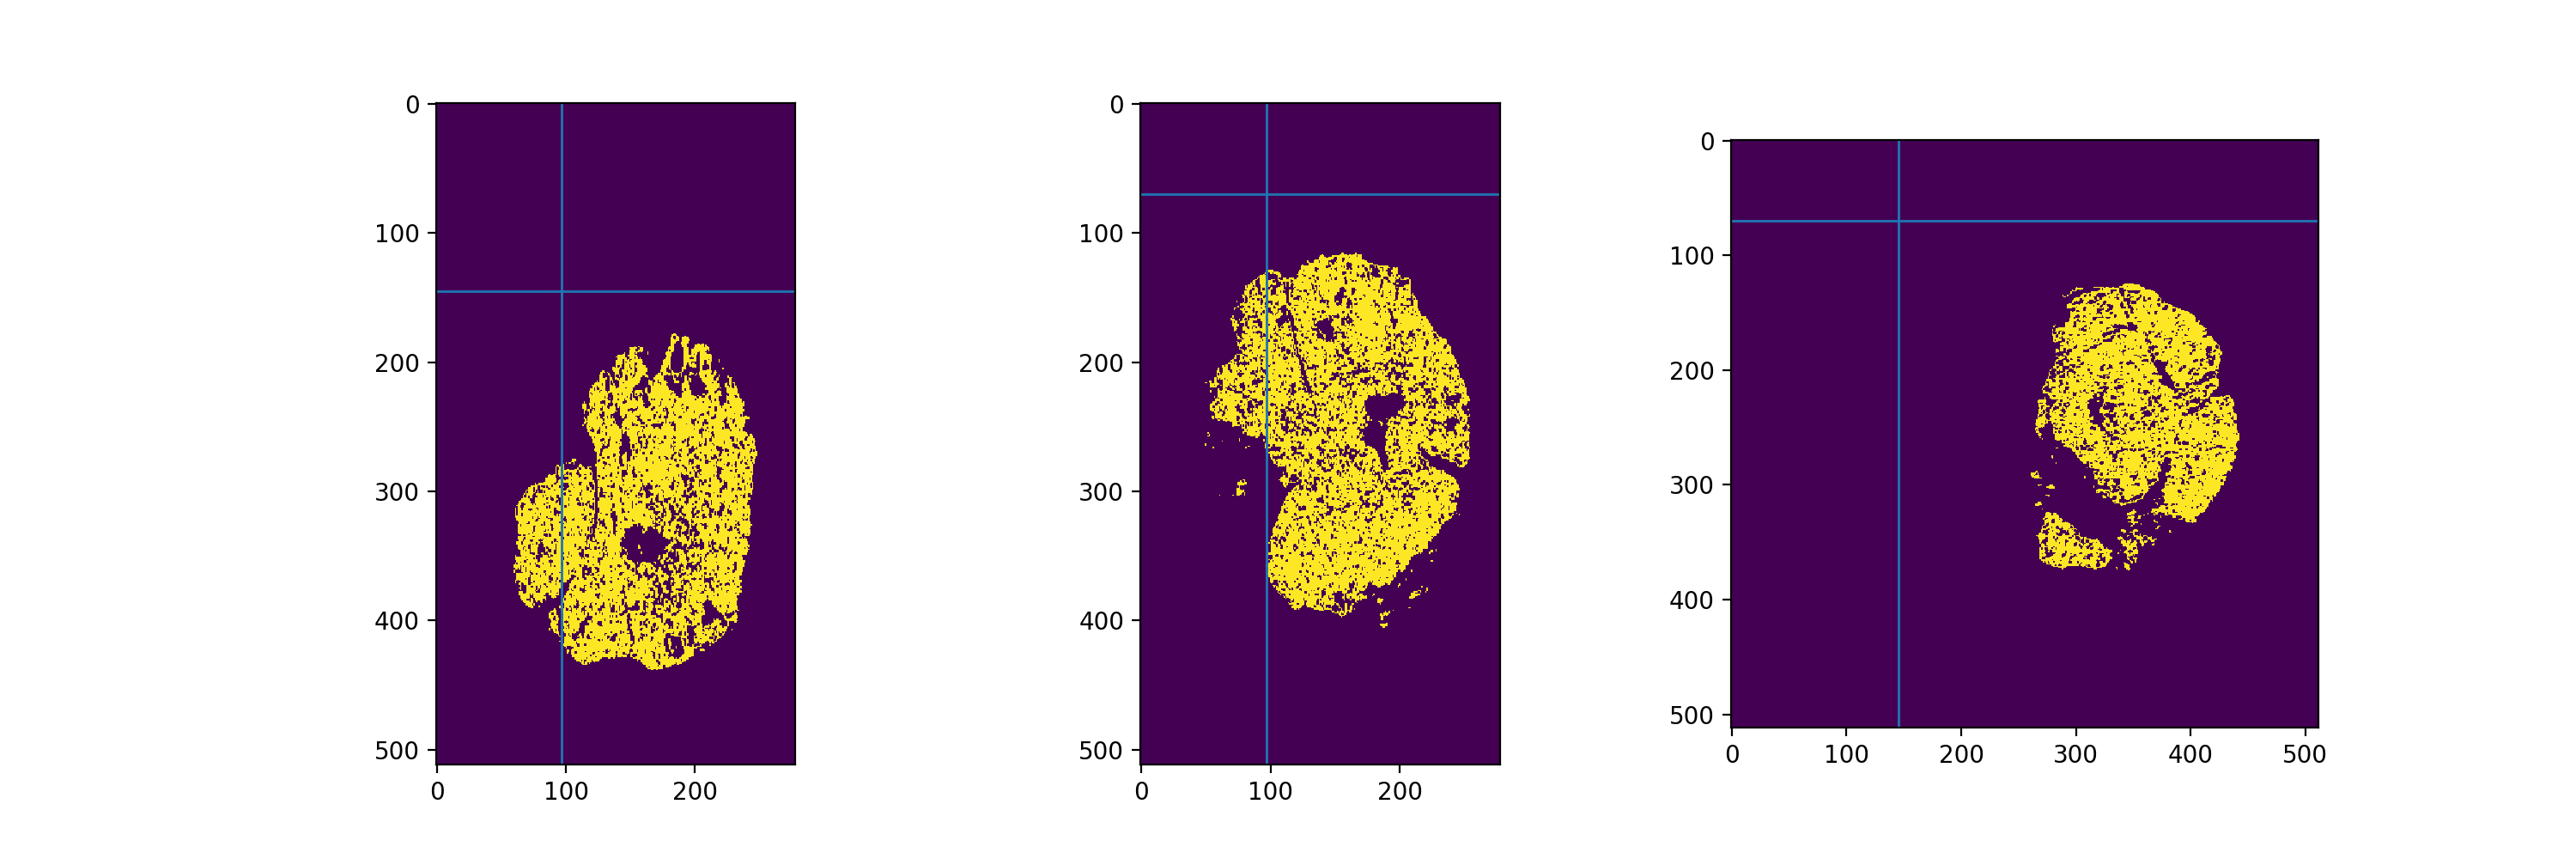

<IPython.core.display.Javascript object>


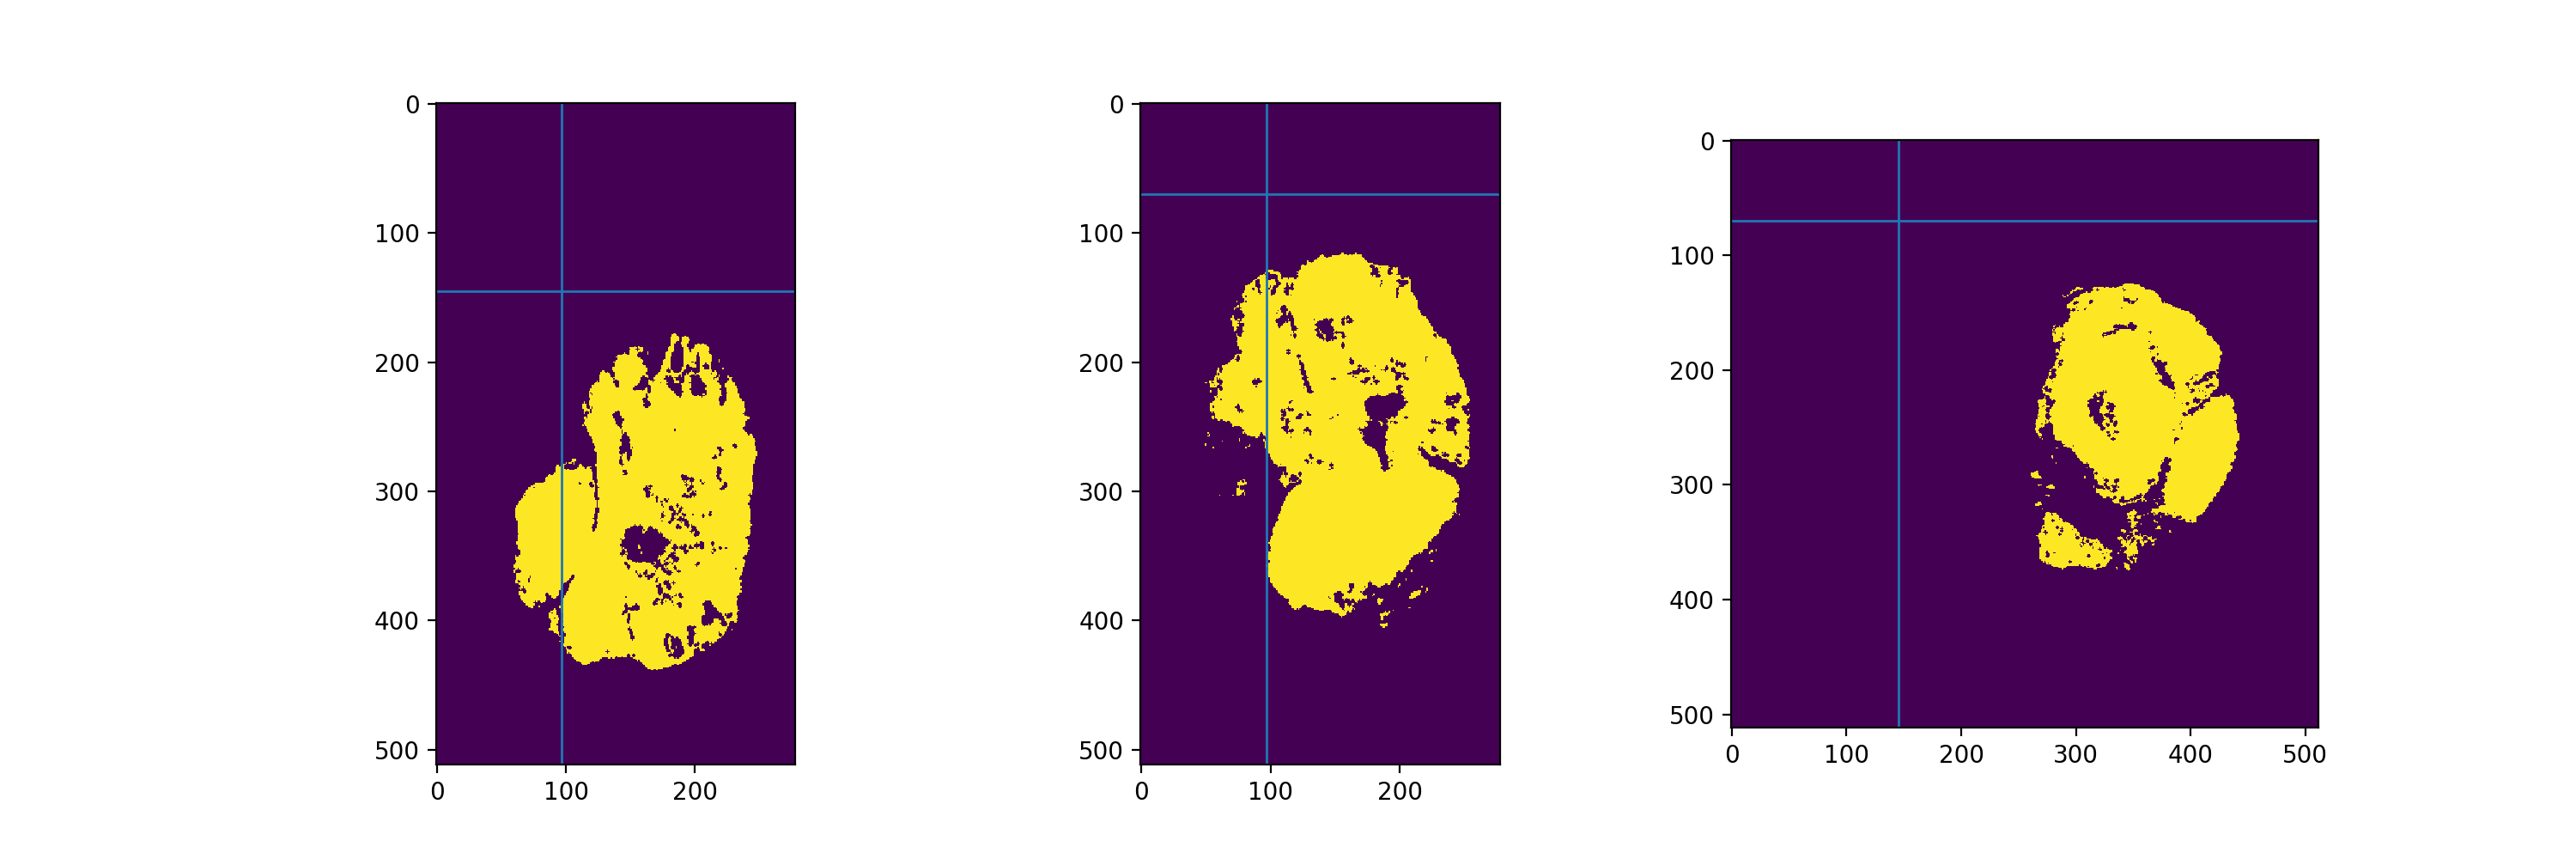

In [162]:
displayMask(ROI_array,ConstPixelSpacing,200,300,100)
displayMask(active_mask,ConstPixelSpacing,200,300,100)

In [164]:
paras[15]

array([b'ScanF', b'0.936545076517', b'0.255291612197', b'-0.240228042477',
       b'284.921196883'],
      dtype='|S17')

In [165]:
# paras = np.load('/Volumes/FAIR/DC-Image-Analysis/DC-project-master/cleancode/NewMidplane/Final_preop.npy')
file, a, b, c, d = paras[15]
a, b, c, d = a.astype(float),b.astype(float),c.astype(float),d.astype(float)
v = np.array((a,b,c))
v = v.astype(float)
print(file, a, b, c, d, path)

# midplane normal vector regulate the direction
if a<0:
    a,b,c,d = a*-1,b*-1,c*-1,d*-1
n = np.array((a,b,c))

#define rotation axis in plane, in z direction correlates to skew angle
from sympy import *
import sympy
x = sympy.symbols('x')
x1 = solve(a*x + b*100 + c*0 - d, x)
x2 = solve(a*x + b*100 + c*100 - d, x)
k = np.array((x1[0]-x2[0],0,-100)).astype(float)
# k = k/np.sqrt((k[0]**2 + k[1]**2 + k[2]**2))
vk_unit = Functions.unit_vector(k)
vk_unit

## Define rotation axis in y direction, correlating to the orientation angle
x = sympy.symbols('x')
x3 = solve(a*x + b*0.0 + c*100.0- d, x)
x4 = solve(a*x + b*100.0 + c*100.0 - d, x)

k2 = np.array((x3[0]-x4[0],-100.0,0.0)).astype(float)
vk2_unit = Functions.unit_vector(k2)
# the new_vk corresponds to the reshaped version of array, as displayed in ITK
# new_vk = Functions.unit_vector(vk_unit*ConstPixelSpacing)
vk2_unit

#the orientation angle
yaxis = np.array((0,1,0))
angle_ori = Functions.ang(vk2_unit,yaxis)
zaxis = np.array((0,0,1))
# angle_skew = Functions.ang(new_vk,zaxis)
angle_skew = Functions.ang(vk_unit,zaxis)

# Convert to degrees
# The skew angle 
A_S = 180.0 - angle_skew/np.pi*180.0
# The orientation angle
A_O = 180.0 - angle_ori/np.pi*180.0

if vk2_unit[0]*vk2_unit[1] < 0.0:
    A_O = -1*A_O
    
if vk_unit[0]*vk_unit[2] < 0.0:
    A_S = -1*A_S
    
# Calculate the x-coordinate of the miplane, should be a uniform value

# Constant mode rotation, points outside the boundaries of the input 
# are filled with constant 0.0. If points

# ML_array = array
# ideal midplane
Ideal_ML = np.multiply(img_array == 1,img_array)
mask = active_mask

r_IML = rotate(Ideal_ML,A_O,mode='constant',axes=(0,1))
r2_IML = rotate(r_IML,A_S,mode='constant',axes=(0,2))

r_mask = rotate(mask,A_O,mode='constant',axes=(0,1))
r2_mask = rotate(r_mask,A_S,mode='constant',axes=(0,2))

# Somehow the rotated mask is not binary, needs clarification.
Binary_Mask = np.zeros(r2_mask.shape)
Binary_Mask[np.abs(r2_mask)>0.5]=1

# x1,y1,z1 = np.nonzero(r2_DML)
# # x1,y1,z1 = x*ConstPixelSpacing[0],y*ConstPixelSpacing[1],z*ConstPixelSpacing[2]
# y1 = y1.astype(int)
# z1 = z1.astype(int)

b'ScanF' 0.936545076517 0.255291612197 -0.240228042477 284.921196883 /Users/fair00542/Desktop/TestImages/ScanF/ScanF


<IPython.core.display.Javascript object>


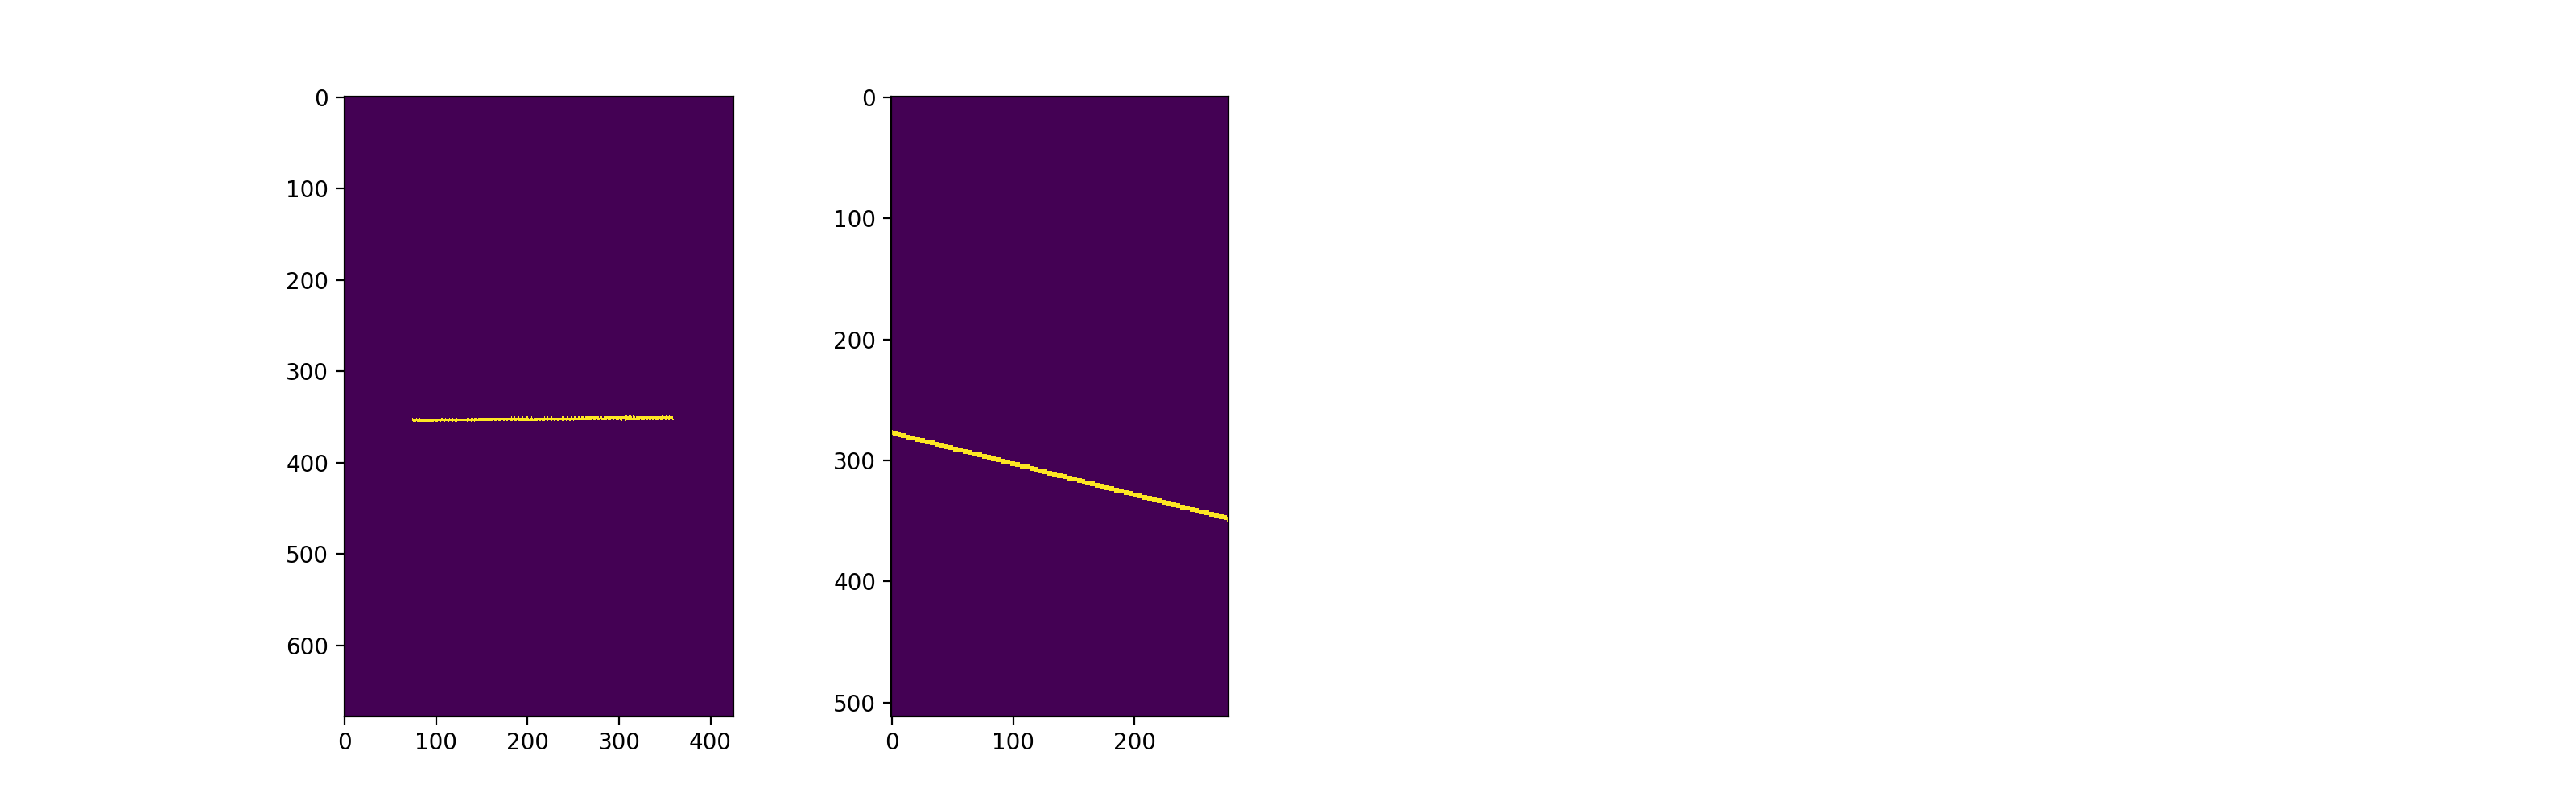

In [166]:
i = 100

plt.figure(figsize=(16,5))
plt.subplot(141)

plt.imshow(r2_IML[:,i,:])
plt.subplot(142)
plt.imshow(Ideal_ML[:,i,:])
plt.show()

<IPython.core.display.Javascript object>


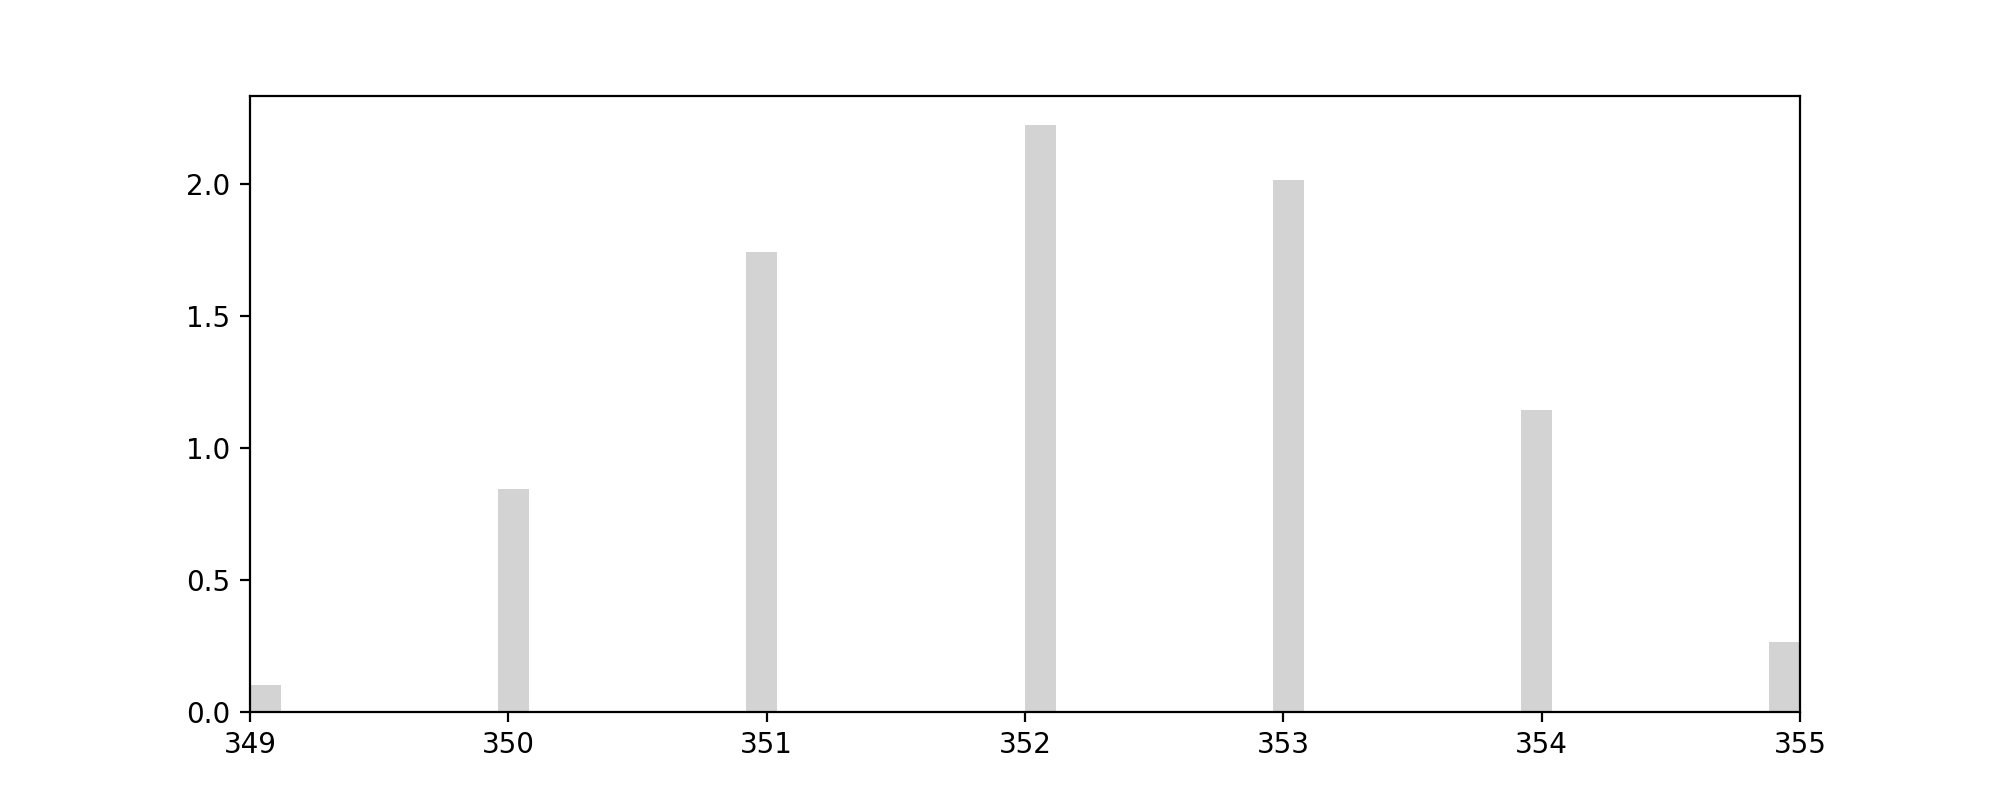

Number of points 542684


In [167]:
# Check the spread range of x1 value should be very small
# Calculate the reference_x coordinates
xr = np.nonzero(r2_IML)[0]
counts = np.bincount(xr)
reference_x = np.argmax(counts)

distribution(xr)

# print('Number of points ' + str(num_pts))
# counts = np.bincount(np.nonzero(r2_IML)[0])
# reference_x = np.argmax(counts)
# print(reference_x)

In [176]:
# Somehow the rotated mask is not binary, needs clarification.
Binary_Mask = np.zeros(r2_mask.shape)
Binary_Mask[np.abs(r2_mask)>0.9995]=1

# Adjust the threshold level until the number of active pixels become approximately the same
np.sum(np.nonzero(mask)),np.sum(np.nonzero(Binary_Mask)),

(4632606692, 4731864308)

<IPython.core.display.Javascript object>


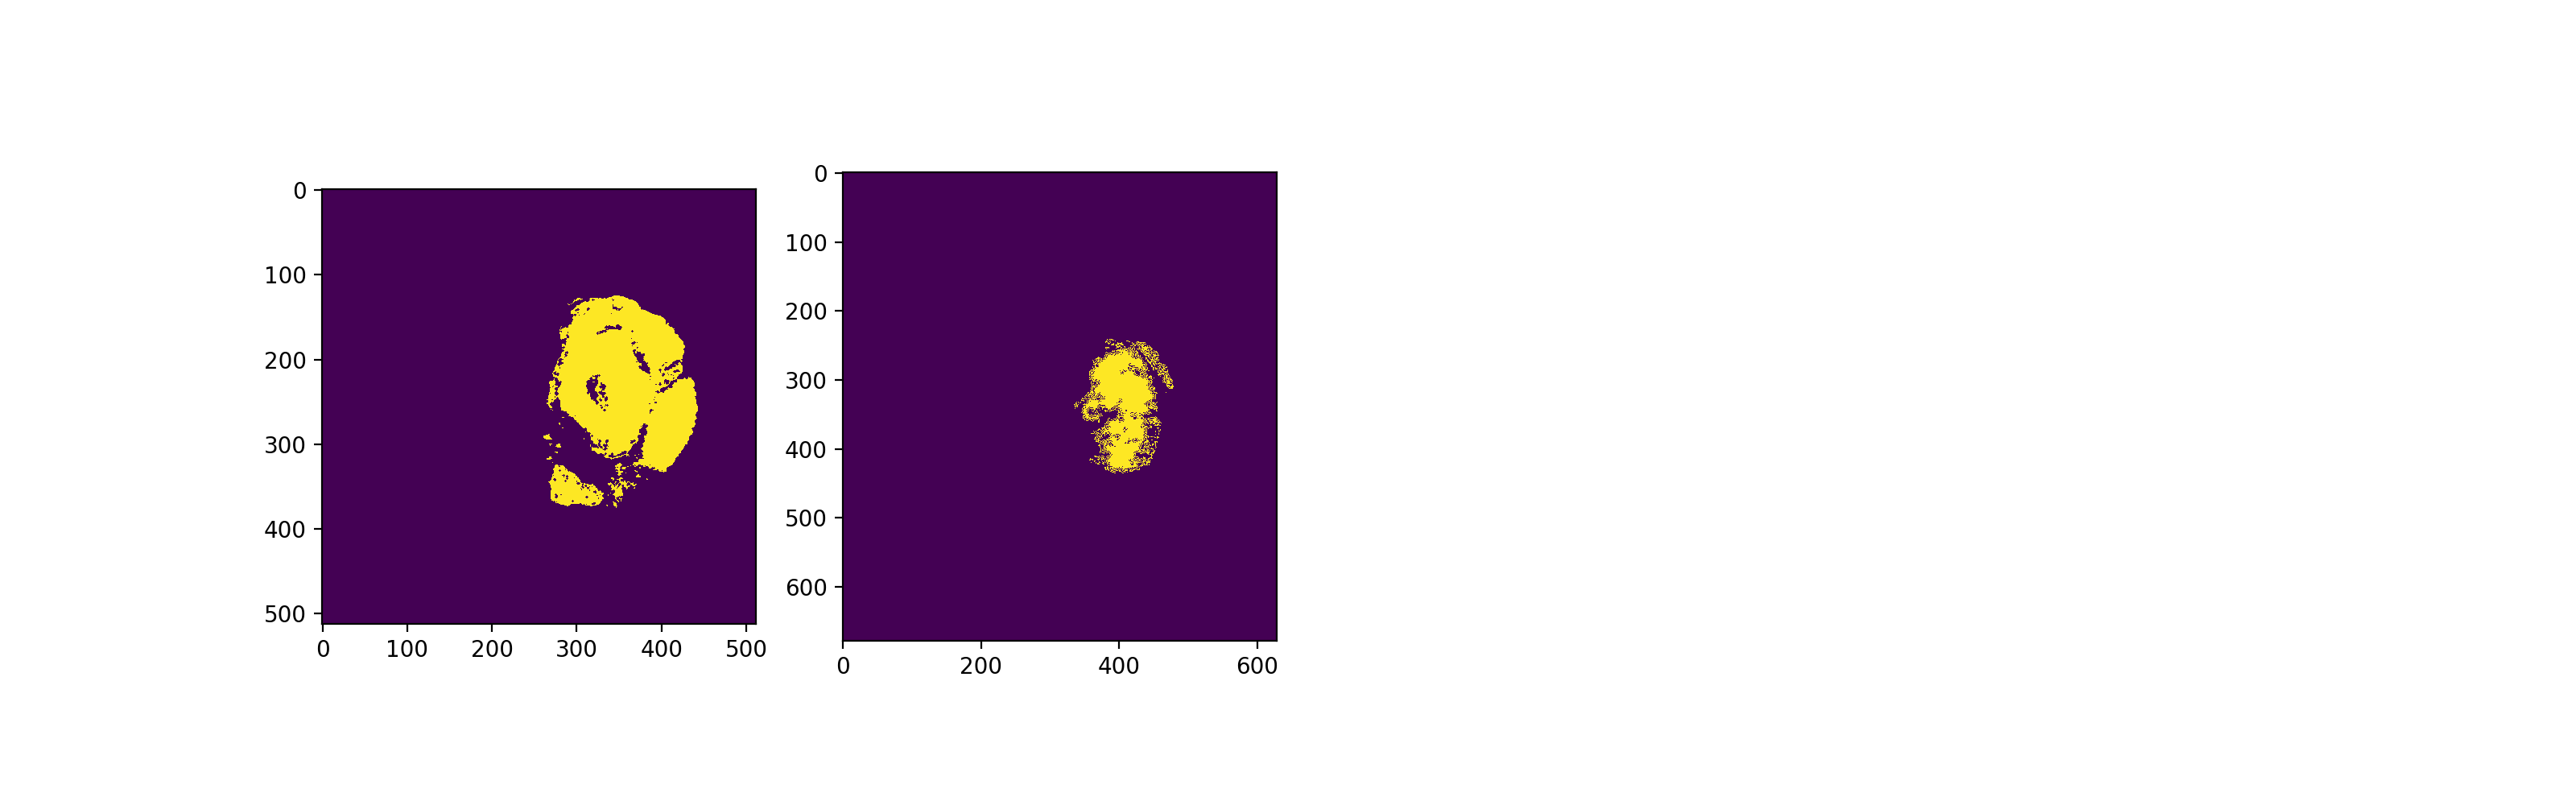

In [189]:
# View the rotation from axial plane
i = 100.0
i2 = int((i/mask.shape[2])*r2_mask.shape[2])

plt.figure(figsize=(16,5))
plt.subplot(141)
plt.imshow(mask[:,:,int(i)])
plt.subplot(142)
plt.imshow(Binary_Mask[:,:,i2])


plt.show()

<IPython.core.display.Javascript object>


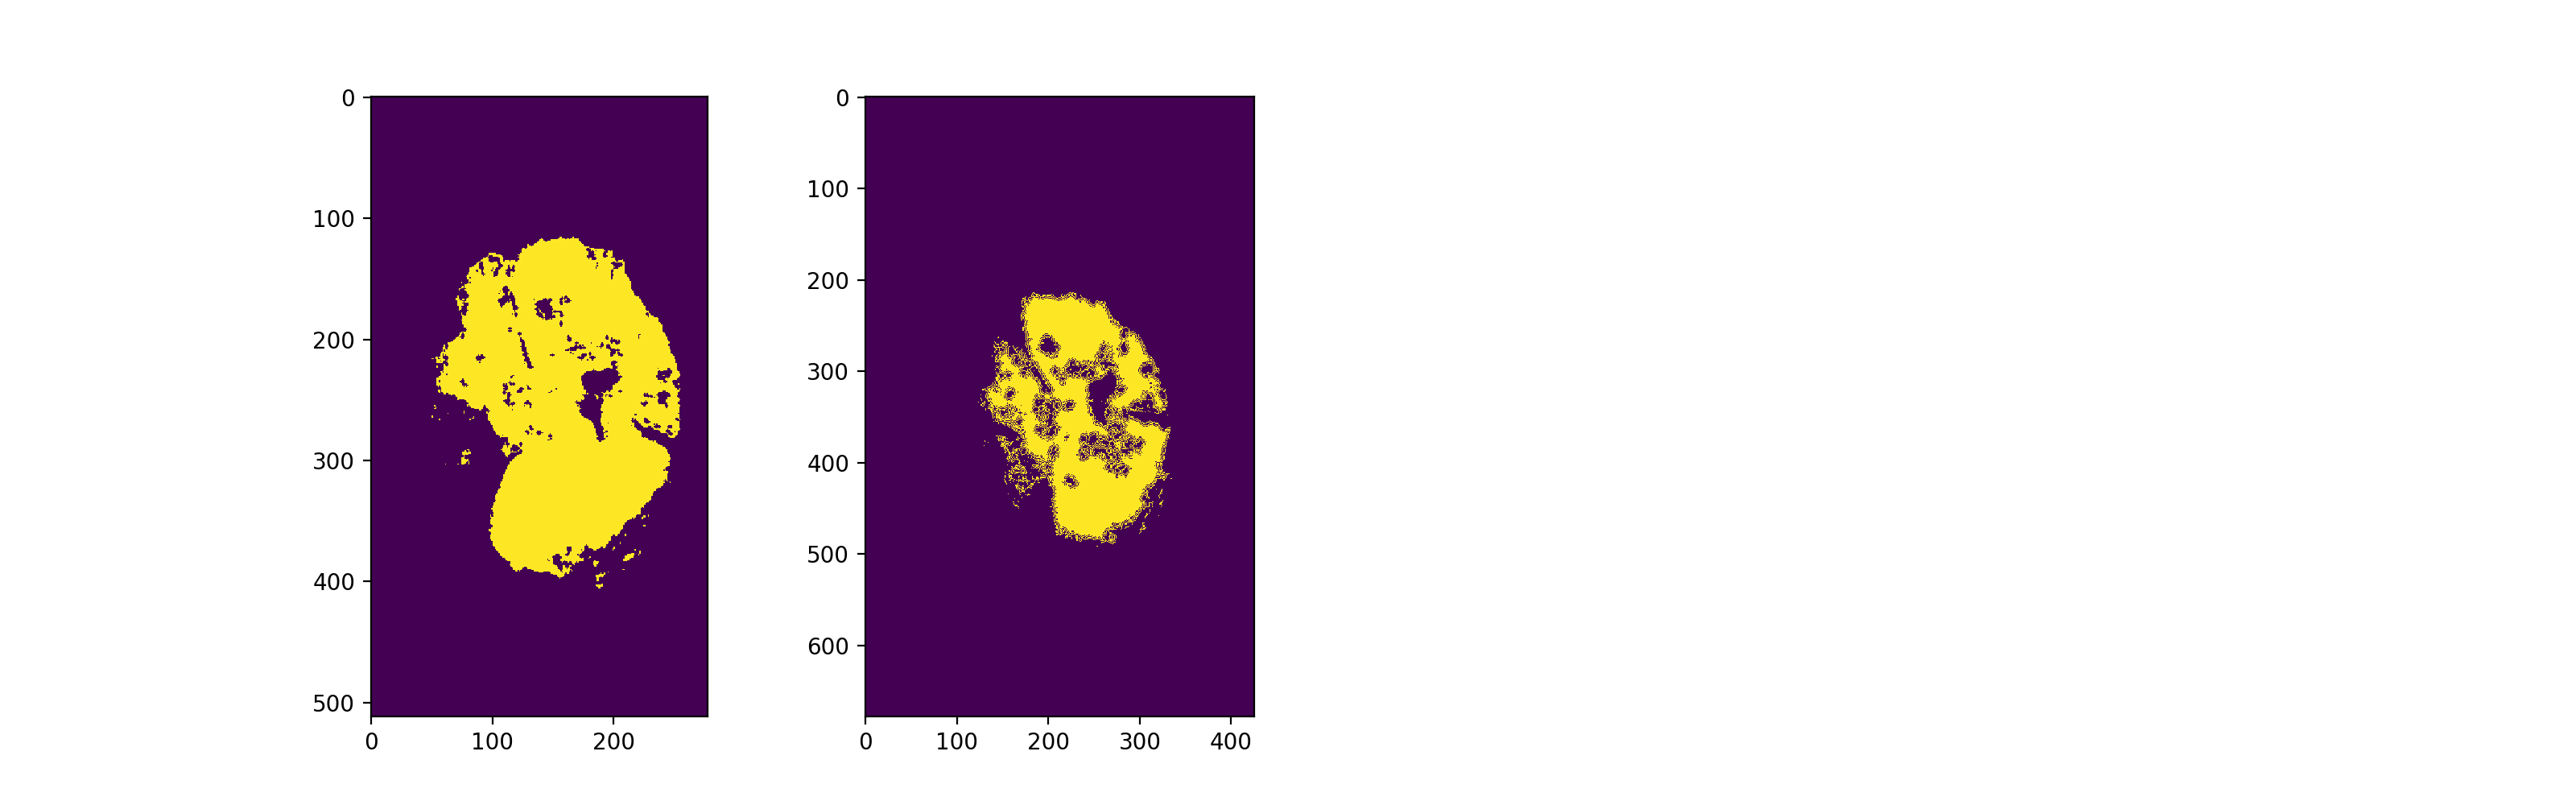

In [190]:
# View the rotation from coronal plane
i1 = 300.0
i2 = int((i1/mask.shape[1])*r2_mask.shape[1])

plt.figure(figsize=(16,5))
plt.subplot(141)
plt.imshow(mask[:,int(i1),:])
plt.subplot(142)
plt.imshow(Binary_Mask[:,i2,:])


plt.show()

In [191]:
midplane_split = np.zeros(r2_IML.shape)
for i in range(reference_x-1,r2_IML.shape[0]):
    midplane_split[i,:,:] = 1

Left_mask = np.multiply(Binary_Mask,midplane_split==0)
Right_mask = np.multiply(Binary_Mask,midplane_split==1)

<IPython.core.display.Javascript object>


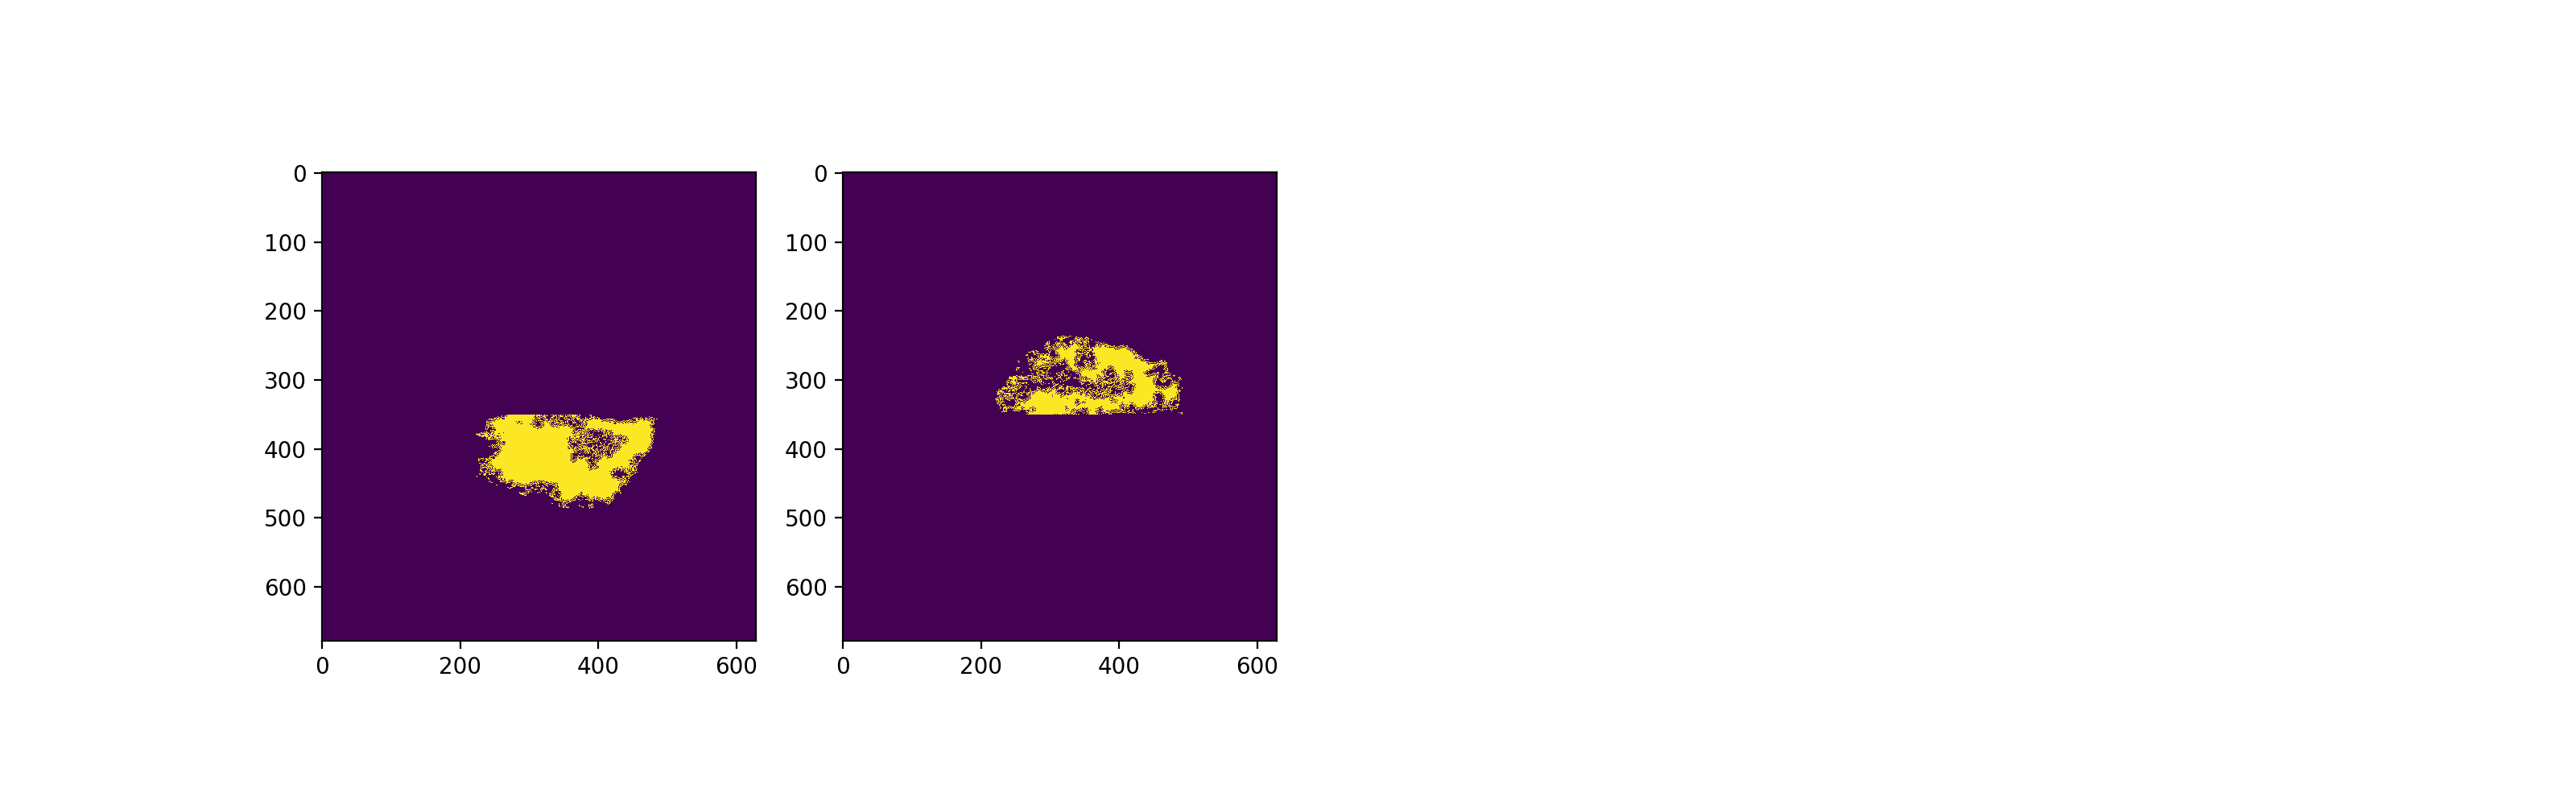

In [192]:
# View the rotation from axial plane
i1 = 180.0
i2 = int((i1/mask.shape[2])*r2_mask.shape[2])

plt.figure(figsize=(16,5))
plt.subplot(141)
plt.imshow(Right_mask[:,:,i2])
plt.subplot(142)
plt.imshow(Left_mask[:,:,i2])


plt.show()

In [193]:
Left_sum = np.sum(Left_mask,0)
Right_sum = np.sum(Right_mask,0)
H_diff = Left_sum-Right_sum
y,z = np.nonzero(H_diff)
# H_diff[H_diff==0]=np.nan

Brain_mask = np.zeros((int(z.max()+1.0),int(y.max()+1.0)))
for i in range(len(z)):
    Brain_mask[z[i],y[i]]= H_diff[y[i],z[i]]

<IPython.core.display.Javascript object>


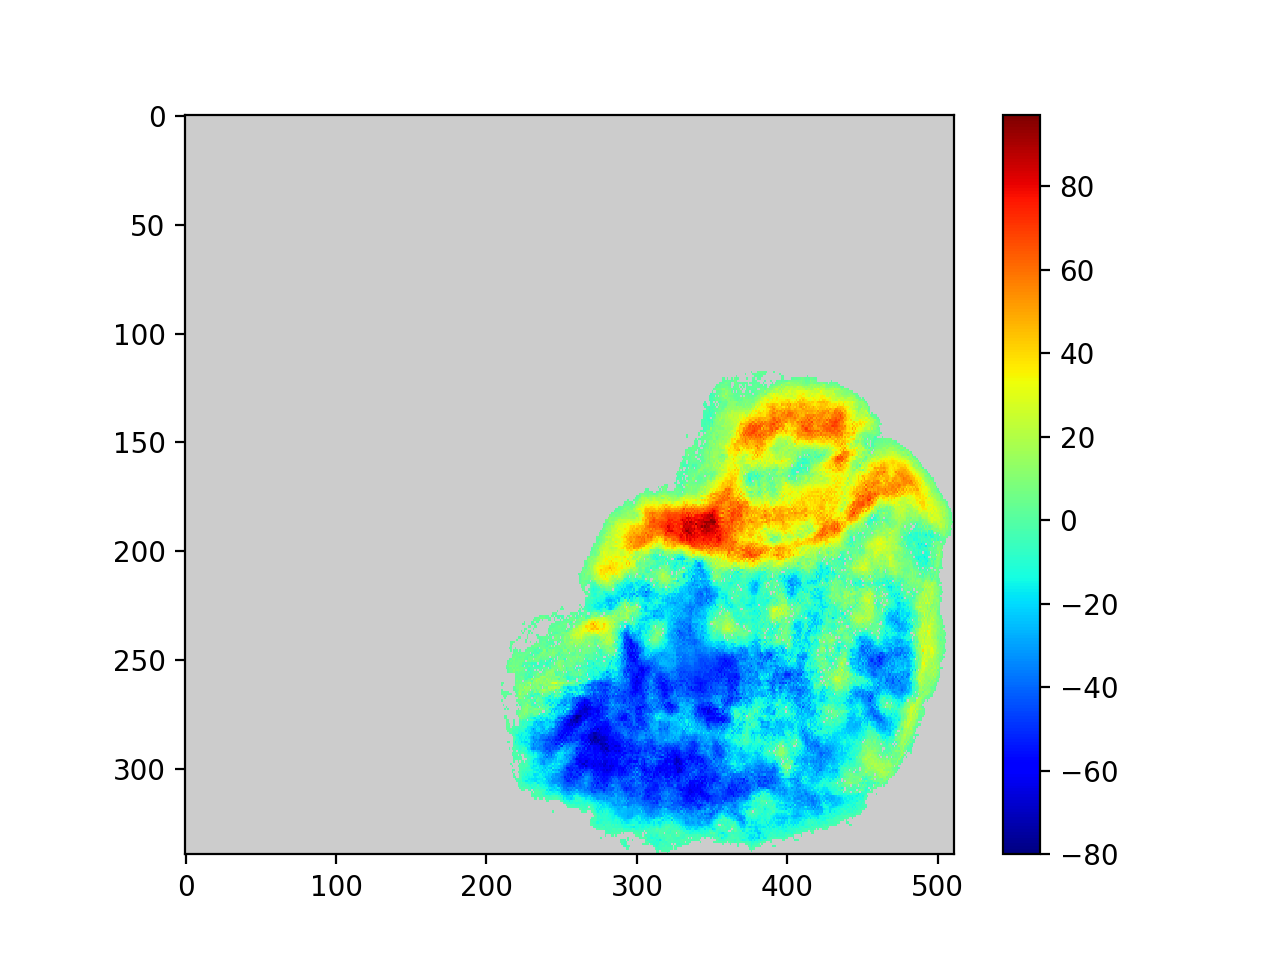

In [197]:
%matplotlib nbagg
fig, ax = plt.subplots()
Brain_mask[Brain_mask==0]=np.nan
palette = plt.cm.jet
palette.set_bad(alpha=0.2)
heatmap = ax.imshow(Brain_mask, cmap=palette)
# heatmap = ax.pcolor(brain_diff==0, cmap=plt.cm.winter)
# plt.ylim(20, z.max())
# plt.ylim(20,140)
# plt.xlim (y.min(),y.max())
# plt.xlim (50,500)
ax.set_aspect(ConstPixelSpacing[2]/ConstPixelSpacing[1])
plt.colorbar(heatmap)
plt.show()
plt.ion()

In [195]:
plt.savefig('B_assymetry_SCF.png')

In [196]:
import scipy.io
mm = np.array([y,z,H_diff[H_diff!=0]])
ConstPixelSpacing = np.array([ConstPixelSpacing[0],ConstPixelSpacing[1],ConstPixelSpacing[2],H_diff.max()])
scipy.io.savemat('B_assymetry_SCF.mat',{'mm':mm,'ConstPixelSpacing':ConstPixelSpacing})